In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
from matplotlib.patches import Patch
from sklearn.preprocessing import StandardScaler, LabelEncoder,MinMaxScaler
from sklearn.impute import KNNImputer
from sklearn.ensemble import RandomForestRegressor,RandomForestClassifier
from sklearn.metrics import mean_squared_error, mean_absolute_error,r2_score,accuracy_score
from sklearn.model_selection import train_test_split
from lightgbm import LGBMRegressor
from sklearn.datasets import make_regression,make_classification

In [2]:
df = pd.read_csv("./archive/compas-scores-two-years-violent.csv")
df.head()

,id,name,first,last,compas_screening_date,sex,dob,age,age_cat,race,...,v_score_text,v_screening_date,in_custody,out_custody,priors_count.1,start,end,event,two_year_recid,two_year_recid.1
0,1,miguel hernandez,miguel,hernandez,2013-08-14,Male,1947-04-18,69,Greater than 45,Other,...,Low,2013-08-14,2014-07-07,2014-07-14,0,0,327,0,0,0
1,3,kevon dixon,kevon,dixon,2013-01-27,Male,1982-01-22,34,25 - 45,African-American,...,Low,2013-01-27,2013-01-26,2013-02-05,0,9,159,1,1,1
2,5,marcu brown,marcu,brown,2013-01-13,Male,1993-01-21,23,Less than 25,African-American,...,Medium,2013-01-13,NaN,NaN,1,0,1174,0,0,0
3,6,bouthy pierrelouis,bouthy,pierrelouis,2013-03-26,Male,1973-01-22,43,25 - 45,Other,...,Low,2013-03-26,NaN,NaN,2,0,1102,0,0,0
4,7,marsha miles,marsha,miles,2013-11-30,Male,1971-08-22,44,25 - 45,Other,...,Low,2013-11-30,2013-11-30,2013-12-01,0,1,853,0,0,0


In [4]:
selected_columns = ['sex','age', 'race', 'juv_fel_count','decile_score',
                    'juv_misd_count','juv_other_count', 'priors_count',
                    'c_jail_in', 'c_jail_out','c_charge_degree', "is_recid", 
                    'is_violent_recid']

In [5]:
df_selected = df.loc[:, selected_columns]
df_selected.head()

,sex,age,race,juv_fel_count,decile_score,juv_misd_count,juv_other_count,priors_count,c_jail_in,c_jail_out,c_charge_degree,is_recid,is_violent_recid
0,Male,69,Other,0,1,0,0,0,2013-08-13 06:03:42,2013-08-14 05:41:20,F,0,0
1,Male,34,African-American,0,3,0,0,0,2013-01-26 03:45:27,2013-02-05 05:36:53,F,1,1
2,Male,23,African-American,0,8,1,0,1,NaN,NaN,F,0,0
3,Male,43,Other,0,1,0,0,2,NaN,NaN,F,0,0
4,Male,44,Other,0,1,0,0,0,2013-11-30 04:50:18,2013-12-01 12:28:56,M,0,0


In [13]:
print(df_selected['race'].unique())
df_selected['race'] = df_selected['race'].map({'Other':0, 'African-American':1,
                                                'Caucasian':2, 'Hispanic':3, 'Asian':4,
                                                 'Native American':5})

['Other' 'African-American' 'Caucasian' 'Hispanic' 'Asian'
 'Native American']


In [18]:
df_selected['c_charge_degree'] = df_selected['c_charge_degree'].map({'F':1,'M':0})

In [ ]:
df_selected['sex'] = df_selected['sex'].map({'Male': 1,'Female': 0}).fillna(-1)
print(df_selected['sex'])

0      -1.0
1      -1.0
2      -1.0
3      -1.0
4      -1.0
       ... 
4738   -1.0
4739   -1.0
4740   -1.0
4741   -1.0
4742   -1.0
Name: sex, Length: 4743, dtype: float64


In [24]:
df_selected_corr = df_selected.drop(columns=['c_jail_in', 'c_jail_out'])

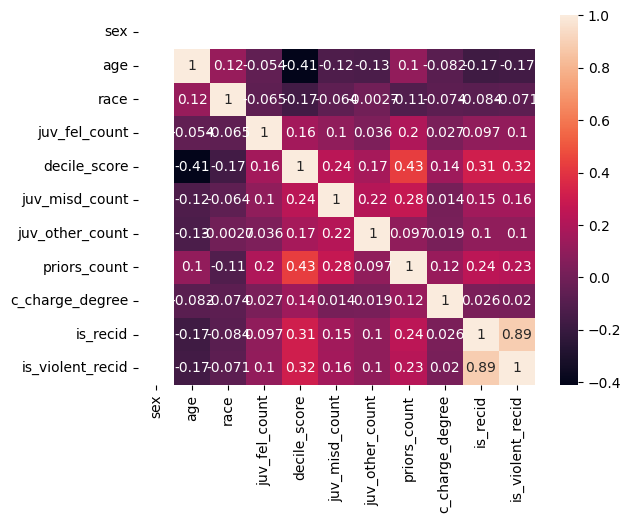

In [25]:
corr = df_selected_corr.corr()
ax = sns.heatmap(corr, annot=True)